<a href="https://colab.research.google.com/github/tdraths/titanic_classification/blob/main/titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')



from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
titanic_test = pd.read_csv('test (1).csv')
titanic_train = pd.read_csv('train (1).csv')

titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
titanic_test.shape

(418, 11)

In [5]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic_nulls = pd.DataFrame(titanic_train.isna().sum().sort_values(ascending=False) / len(titanic_train), 
                             columns=['percent', ])
percent_null = titanic_nulls['percent'] > 0
titanic_nulls[percent_null]

,percent
Cabin,0.771044
Age,0.198653
Embarked,0.002245


In [7]:
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

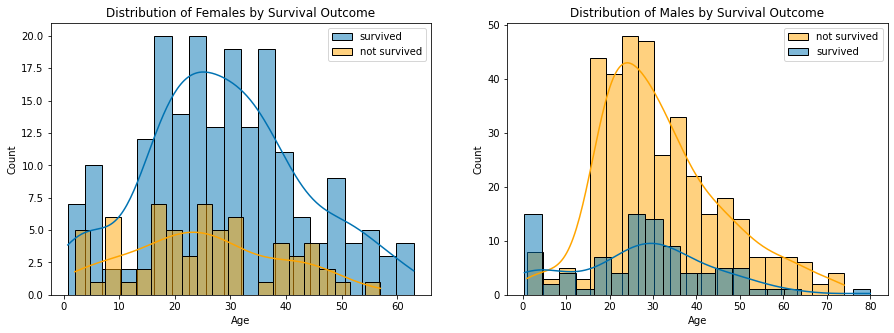

In [8]:
survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(1, 2, figsize=(15,5))

females = titanic_train[titanic_train['Sex'] == 'female']
males = titanic_train[titanic_train['Sex'] == 'male']

ax = sns.histplot(females[females['Survived'] == 1].Age.dropna(), bins=20, label=survived, ax=axes[0], kde=True)
ax = sns.histplot(females[females['Survived'] == 0].Age.dropna(), bins=20, label=not_survived, ax=axes[0], kde=True, color='orange')
ax.set_title('Distribution of Females by Survival Outcome')
ax.legend();

ax = sns.histplot(males[males['Survived'] == 0].Age.dropna(), bins=20, label=not_survived, ax=axes[1], kde=True, color='orange')
ax = sns.histplot(males[males['Survived'] == 1].Age.dropna(), bins=20, label=survived, ax=axes[1], kde=True)
ax.set_title('Distribution of Males by Survival Outcome')
ax.legend();

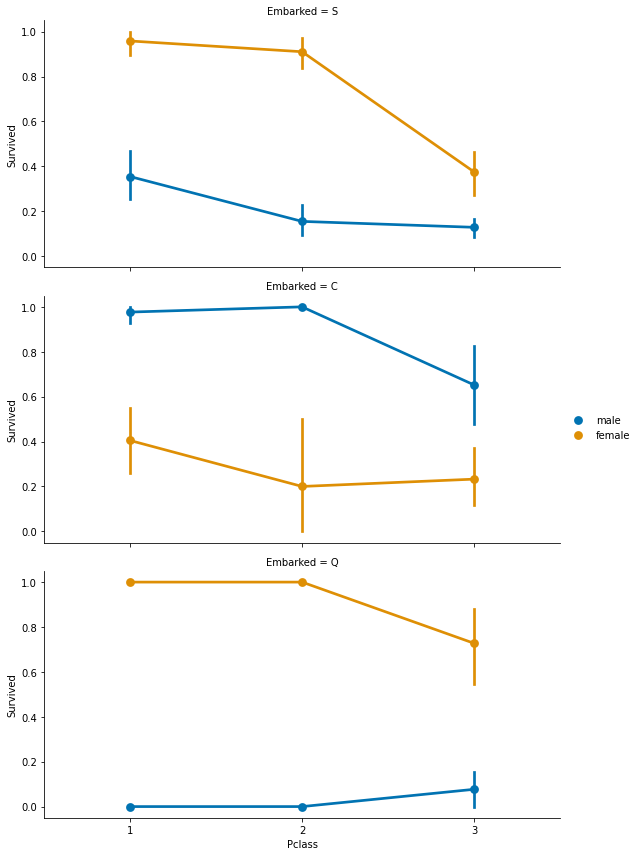

In [9]:
FacetGrid = sns.FacetGrid(titanic_train, row='Embarked', height=4, aspect=2)

FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='colorblind', order=None, hue_order=None)
FacetGrid.add_legend();

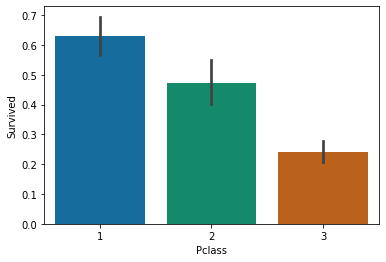

In [10]:
sns.barplot(x='Pclass', y='Survived', data=titanic_train);

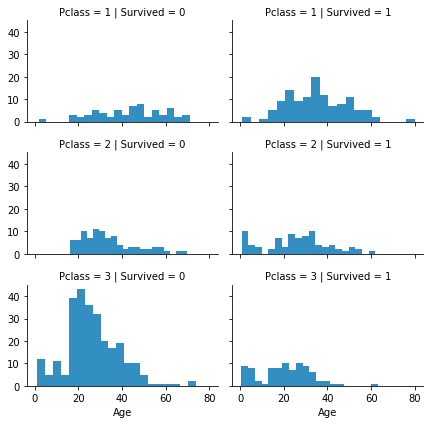

In [11]:
grid = sns.FacetGrid(titanic_train, col='Survived', row='Pclass', height=2, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=.8, bins=20)
grid.add_legend();

In [12]:
datasets = [titanic_train, titanic_test]

for data in datasets:
    data['relatives'] = data['SibSp'] + data['Parch']
    data.loc[data['relatives'] > 0, 'with_family'] = 0
    data.loc[data['relatives'] == 0, 'with_family'] = 1
    data['with_family'] = data['with_family'].astype(int)

titanic_train['with_family'].value_counts()

1    537
0    354
Name: with_family, dtype: int64

In [13]:
titanic_train = titanic_train.drop(['PassengerId'], axis=1)

In [14]:
deck = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8}

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
dfs = [titanic_train, titanic_test]

for df in dfs:
    df['Cabin'] = df['Cabin'].fillna("U0")
    df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    df['Deck'] = df['Deck'].map(deck)
    df['Deck'] = df['Deck'].fillna(0)
    df['Deck'] = df['Deck'].astype(int)

titanic_train = titanic_train.drop(['Cabin'], axis=1)
titanic_test = titanic_test.drop(['Cabin'], axis=1)

In [15]:
dfs = [titanic_train, titanic_test]

for df in dfs:
    mean = titanic_train['Age'].mean()
    std = titanic_test['Age'].std()
    is_null = df['Age'].isna().sum()
    
    random_age = np.random.randint(mean - std, mean + std, size=is_null)
    
    age_segment = df['Age'].copy()
    age_segment[np.isnan(age_segment)] = random_age
    df['Age'] = age_segment
    df['Age'] = titanic_train['Age'].astype(int)
    
titanic_train['Age'].isna().sum()
    

0

In [16]:
titanic_train.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [17]:
top = 'S'
dfs = [titanic_train, titanic_test]

for df in dfs:
    df['Embarked'] = df['Embarked'].fillna(top)

In [18]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  relatives    891 non-null    int64  
 11  with_family  891 non-null    int64  
 12  Deck         891 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


In [19]:
pd.qcut(titanic_train['Age'], q=6)

0      (18.0, 23.0]
1      (34.0, 41.0]
2      (23.0, 28.0]
3      (34.0, 41.0]
4      (34.0, 41.0]
           ...     
886    (23.0, 28.0]
887    (18.0, 23.0]
888    (18.0, 23.0]
889    (23.0, 28.0]
890    (28.0, 34.0]
Name: Age, Length: 891, dtype: category
Categories (6, interval[float64]): [(-0.001, 18.0] < (18.0, 23.0] < (23.0, 28.0] < (28.0, 34.0] <
                                    (34.0, 41.0] < (41.0, 80.0]]

In [20]:
pd.qcut(titanic_train['Fare'], q=6, precision=2)

0        (-0.01, 7.78]
1      (52.37, 512.33]
2         (7.78, 8.66]
3      (52.37, 512.33]
4         (7.78, 8.66]
            ...       
886      (8.66, 14.45]
887      (26.0, 52.37]
888      (14.45, 26.0]
889      (26.0, 52.37]
890      (-0.01, 7.78]
Name: Fare, Length: 891, dtype: category
Categories (6, interval[float64]): [(-0.01, 7.78] < (7.78, 8.66] < (8.66, 14.45] < (14.45, 26.0] <
                                    (26.0, 52.37] < (52.37, 512.33]]

In [21]:
dfs = [titanic_train, titanic_test]
titles = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
genders = {'male': 0, 'female': 1}
ports = {'S': 0, 'C': 1, 'Q': 2}

for df in dfs:
    df['Fare'] = df['Fare'].fillna(0)
    df['Fare'] = df['Fare'].astype(int)
    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 
                                       'Col', 'Don', 'Dr', 'Major', 
                                       'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].map(titles)
    df['Title'] = df['Title'].fillna(0)
    
    df['Sex'] = df['Sex'].map(genders)
    
    df['Embarked'] = df['Embarked'].map(ports)
    
    df['Age'] = df['Age'].astype(int)
    df.loc[df['Age'] <= 18, 'Age'] = 0
    df.loc[(df['Age'] > 18) & (df['Age'] <= 23), 'Age'] = 1
    df.loc[(df['Age'] > 23) & (df['Age'] <= 28), 'Age'] = 2
    df.loc[(df['Age'] > 28) & (df['Age'] <= 34), 'Age'] = 3
    df.loc[(df['Age'] > 34) & (df['Age'] <= 41), 'Age'] = 4
    df.loc[(df['Age'] > 41) & (df['Age'] <= 80), 'Age'] = 5
    
    df.loc[df['Fare'] <= 7.78, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.78) & (df['Fare'] <= 8.66), 'Fare'] = 1
    df.loc[(df['Fare'] > 8.66) & (df['Fare'] <= 14.45), 'Fare'] = 2
    df.loc[(df['Fare'] > 14.45) & (df['Fare'] <= 26.0), 'Fare'] = 3
    df.loc[(df['Fare'] > 26.0) & (df['Fare'] <= 52.37), 'Fare'] = 4
    df.loc[(df['Fare'] > 52.37) & (df['Fare'] <= 512.33), 'Fare'] = 5
    df.loc[df['Fare'] > 512.33, 'Fare'] = 6
    df['Fare'] = df['Fare'].astype(int)

    
    

    
titanic_train = titanic_train.drop(['Name'], axis=1)
titanic_test = titanic_test.drop(['Name'], axis=1)

display(titanic_train['Age'].value_counts())
display(titanic_train['Fare'].value_counts())

0    162
2    150
3    149
5    145
1    144
4    141
Name: Age, dtype: int64

0    241
3    165
5    146
2    146
4    123
1     70
Name: Fare, dtype: int64

In [22]:
titanic_train.Ticket.describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [23]:
titanic_train.drop(['Ticket'], axis=1, inplace=True)
titanic_test.drop(['Ticket'], axis=1, inplace=True)

In [24]:
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,with_family,Deck,Title
0,0,3,0,1,1,0,0,0,1,0,8,1
1,1,1,1,4,1,0,5,1,1,0,3,3
2,1,3,1,2,0,0,0,0,0,1,8,2
3,1,1,1,4,1,0,5,0,1,0,3,3
4,0,3,0,4,0,0,1,0,0,1,8,1


In [25]:
dfs = [titanic_train, titanic_test]

for df in dfs:
    df['Age_Class'] = df['Age'] * df['Pclass']
    
    df['Fare_per_passenger'] = df['Fare'] / (df['relatives']+1)
    df['Fare_per_passenger'] = df['Fare_per_passenger'].astype(int)

In [26]:
titanic_train.columns = titanic_train.columns.str.lower()
titanic_test.columns = titanic_test.columns.str.lower()

In [27]:
display('Titanic_Train', titanic_train.head())
display('Titanic_Test', titanic_test.head())

'Titanic_Train'

,survived,pclass,sex,age,sibsp,parch,fare,embarked,relatives,with_family,deck,title,age_class,fare_per_passenger
0,0,3,0,1,1,0,0,0,1,0,8,1,3,0
1,1,1,1,4,1,0,5,1,1,0,3,3,4,2
2,1,3,1,2,0,0,0,0,0,1,8,2,6,0
3,1,1,1,4,1,0,5,0,1,0,3,3,4,2
4,0,3,0,4,0,0,1,0,0,1,8,1,12,1


'Titanic_Test'

,passengerid,pclass,sex,age,sibsp,parch,fare,embarked,relatives,with_family,deck,title,age_class,fare_per_passenger
0,892,3,0,1,0,0,0,2,0,1,8,1,3,0
1,893,3,1,4,1,0,0,0,1,0,8,3,12,0
2,894,2,0,2,0,0,2,2,0,1,8,1,4,2
3,895,3,0,4,0,0,1,0,0,1,8,1,12,1
4,896,3,1,4,1,1,2,0,2,0,8,3,12,0


In [28]:
X_train = titanic_train.drop('survived', axis=1)
y_train = titanic_train['survived']

X_test = titanic_test.drop('passengerid', axis=1).copy()

In [29]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

accuracy_sgd = round(sgd.score(X_train, y_train) * 100, 2)

In [30]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

accuracy_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

accuracy_logreg = round(logreg.score(X_train, y_train) * 100, 2)

In [32]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_knn = round(knn.score(X_train, y_train) * 100, 2)

In [33]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

accuracy_gauss = round(gauss.score(X_train, y_train) * 100, 2)

In [34]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

accuracy_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)

In [35]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy_xgb_classifier = round(xgb_classifier.score(X_train, y_train) * 100, 2)

In [36]:
xgb_rf = xgb.XGBRFClassifier(random_state=42)
xgb_rf.fit(X_train, y_train)
y_pred = xgb_rf.predict(X_test)

accuracy_xgb_rf = round(xgb_rf.score(X_train, y_train) * 100, 2)

In [37]:
results = pd.DataFrame(
    {'Model': ['Stochastic Gradient Descent', 'Random Forest', 'Logistic Regression', 'KNN', 
               'Naive Bayes', 'Decision Tree', 'XGBoost', 'XGBoost w/ Random Forest'],
     'Score': [accuracy_sgd, accuracy_random_forest, accuracy_logreg, accuracy_knn,
               accuracy_gauss, accuracy_decision_tree, accuracy_xgb_classifier, accuracy_xgb_rf]})

results = results.sort_values(by='Score', ascending=False).set_index('Score')
results.head(6)

,Model
Score,
92.93,Random Forest
92.93,Decision Tree
87.21,KNN
86.64,XGBoost
83.61,XGBoost w/ Random Forest
81.26,Logistic Regression


In [38]:
clf = RandomForestClassifier()

param_grid = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

display(grid_clf.best_estimator_)
display(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

{'max_depth': 6, 'n_estimators': 25}

In [42]:
clf = RandomForestClassifier(max_depth=6, n_estimators=25)
clf.fit(X_train, y_train)
clf.predict(X_test)

feature_importances = pd.DataFrame({'feature': X_train.columns, 
                                    'importance': np.round(clf.feature_importances_,3)})

feature_importances = feature_importances.sort_values('importance', ascending=False).set_index('feature')

accuracy_clf = round(clf.score(X_train, y_train)*100, 2)
print('Accuracy Score:', accuracy_clf)
feature_importances.head(15)

Accuracy Score: 87.32


,importance
feature,
sex,0.258
title,0.257
pclass,0.100
fare,0.078
relatives,0.065
deck,0.061
fare_per_passenger,0.060
age_class,0.053
sibsp,0.040


In [43]:
titanic_train = titanic_train.drop(columns=['embarked', 'parch', 'with_family'])
titanic_test = titanic_test.drop(columns=['embarked', 'parch', 'with_family'])

X_train = titanic_train.drop('survived', axis=1)
y_train = titanic_train['survived']

X_test = titanic_test.drop('passengerid', axis=1).copy()

KeyError: ignored

In [44]:
clf = RandomForestClassifier(max_depth=7, n_estimators=35)
clf.fit(X_train, y_train)
clf.predict(X_test)

feature_importances = pd.DataFrame({'feature': X_train.columns, 
                                    'importance': np.round(clf.feature_importances_,3)})

feature_importances = feature_importances.sort_values('importance', ascending=False).set_index('feature')

accuracy_clf = round(clf.score(X_train, y_train)*100, 2)
print('Accuracy Score:', accuracy_clf)
feature_importances.head(15)

Accuracy Score: 87.54


,importance
feature,
title,0.257
sex,0.235
pclass,0.100
relatives,0.082
deck,0.082
fare,0.063
age_class,0.055
fare_per_passenger,0.055
age,0.038


In [54]:
param_grid = {'n_estimators': [i for i in range(10, 500, 20)],
              'max_depth': [i for i in range(1, 20, 1)],
             }

clf = RandomForestClassifier(random_state=42)

grid_clf = GridSearchCV(clf, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

display(grid_clf.best_estimator_)
display(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

{'max_depth': 4, 'n_estimators': 150}

In [55]:
clf = RandomForestClassifier(max_depth=4, n_estimators=150)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', round(clf.score(X_train, y_train) * 100, 2))

Accuracy: 83.95


In [56]:
clf.predict_proba(X_test)

array([[0.890181  , 0.109819  ],
       [0.45074494, 0.54925506],
       [0.86623039, 0.13376961],
       [0.90452118, 0.09547882],
       [0.45283745, 0.54716255],
       [0.89700942, 0.10299058],
       [0.49168396, 0.50831604],
       [0.77716342, 0.22283658],
       [0.37959289, 0.62040711],
       [0.8437619 , 0.1562381 ],
       [0.89789638, 0.10210362],
       [0.77440363, 0.22559637],
       [0.04921192, 0.95078808],
       [0.85907362, 0.14092638],
       [0.05252769, 0.94747231],
       [0.16050062, 0.83949938],
       [0.85968056, 0.14031944],
       [0.91065433, 0.08934567],
       [0.44494393, 0.55505607],
       [0.4133237 , 0.5866763 ],
       [0.71101795, 0.28898205],
       [0.52599527, 0.47400473],
       [0.11521002, 0.88478998],
       [0.73580381, 0.26419619],
       [0.10069548, 0.89930452],
       [0.89725284, 0.10274716],
       [0.04692826, 0.95307174],
       [0.890181  , 0.109819  ],
       [0.62436556, 0.37563444],
       [0.87362222, 0.12637778],
       [0.

In [57]:
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [59]:
submission = pd.DataFrame({'PassengerID':titanic_test['passengerid'], 'Survived':y_pred})
submission.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [60]:
filename = 'Titanic Predictions 1.csv'
submission.to_csv(filename, index=False)
print('Saved file: ' + filename)

Saved file: Titanic Predictions 1.csv
